# baseline report

**prep data**
1. filter only 'Sleep stage W', 'Sleep stage 4' labels
2. train valid split by person
3. min max scale EEG data

**metrics**

|label |precision  | recall|
--- | --- | ---|
|sleep stage 4|0.9699|0.9215|
|sleep stage W|0.9992|0.5170|


In [1]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, PrecisionRecallDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from tqdm.notebook import tqdm

# load data

In [2]:
train_data = np.load('../data/raw/train_samples.win500.npy', allow_pickle=True)
test_data = np.load('../data/raw/two_stage_test.npy', allow_pickle=True)

In [3]:
train_data.shape, test_data.shape

((324552,), (15696,))

In [4]:
df_train = pd.DataFrame(list(train_data))
df_test = pd.DataFrame(list(test_data))

In [5]:
df_train.head()

,label,time,value,person
0,Sleep stage W,0,"[[-72.44151404151403, 1.0683760683760717], [-7...",SC4022
1,Sleep stage W,5,"[[-8.093772893772893, 2.3504273504273536], [-1...",SC4022
2,Sleep stage W,10,"[[62.52039072039072, 7.136752136752141], [70.4...",SC4022
3,Sleep stage W,15,"[[-3.2302808302808286, 1.2393162393162427], [-...",SC4022
4,Sleep stage W,20,"[[-12.770207570207567, -12.094017094017088], [...",SC4022


In [6]:
df_train_ch = df_train[df_train['label'].isin(['Sleep stage W', 'Sleep stage 4'])]

In [7]:
df_train_ch.shape

(234996, 4)

# prep data

In [8]:
train_persons, valid_persons = train_test_split(df_train['person'].unique(), test_size=0.1)

In [9]:
ss4_count = df_train[df_train['person'].isin(list(train_persons)) & (df_train['label'] == 'Sleep stage 4')].shape[0]

In [10]:
ssw_count = df_train[df_train['person'].isin(list(train_persons)) & (df_train['label'] == 'Sleep stage W')].shape[0]

In [11]:
ss4_count / (ss4_count + ssw_count)

0.01447352550958871

In [12]:
ss4_valid_count = df_train[df_train['person'].isin(list(valid_persons)) & (df_train['label'] == 'Sleep stage 4')].shape[0]

In [13]:
ssw_valid_count = df_train[df_train['person'].isin(list(valid_persons)) & (df_train['label'] == 'Sleep stage W')].shape[0]

In [14]:
ss4_valid_count / (ss4_valid_count + ssw_valid_count)

0.015661446184605132

In [15]:
def min_max_scaler(y):
    y_ = y.T
    y_min = y_.min(axis=1).reshape(-1, 1)
    y_max = y_.max(axis=1).reshape(-1, 1)
    res = (y_ - y_min) / (y_max - y_min)
    return res.T

In [16]:
def train_valid_prep(data, train_person_list=None, valid_preson_list=None):
    train_feature_flatten = []
    train_target_list = []
    valid_feature_flatten = []
    valid_target_list = []
    
    for row in tqdm(data):
        if row['label'] == 'Sleep stage 4':
            target = 1
        elif row['label'] == 'Sleep stage W':
            target = 0
        else:
            continue
        
        if  train_person_list is None or row['person'] in train_person_list:
            value_scaled = min_max_scaler(row['value'])
            train_feature_flatten.append(value_scaled.flatten().astype(np.float32))
            train_target_list.append(target)
            
        elif row['person'] in valid_preson_list:
            value_scaled = min_max_scaler(row['value'])
            valid_feature_flatten.append(value_scaled.flatten().astype(np.float32))
            valid_target_list.append(target)
            
            
        
    return np.array(train_feature_flatten), np.array(train_target_list), np.array(valid_feature_flatten), np.array(valid_target_list)

In [17]:
X_train, y_train, X_valid, y_valid = train_valid_prep(train_data, train_persons, valid_persons)
X_test, y_test, _, _ = train_valid_prep(test_data)

C:\Users\tarel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [19]:
X_train[:2], X_test[:2]

(array([[0.57221913, 0.11949685, 0.4825678 , ..., 0.14814815, 0.5113448 ,
         0.3906359 ],
        [0.44766507, 0.2644135 , 0.3900966 , ..., 0.1742876 , 0.40619966,
         0.60503644]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [3]:
X_test[4][:4]

NameError: name 'X_test' is not defined

In [36]:
np.array([all(x) for x in np.isnan(X_train)]).mean()

0.0

In [35]:
np.array([all(x) for x in np.isnan(X_test)]).mean()

0.005479102956167176

In [33]:
ind_nan = np.where(np.array([all(x) for x in np.isnan(X_test)]))[0]

In [34]:
y_test[ind_nan]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
y_train.mean(), y_valid.mean(), y_test.mean()

(0.016406156783200097, 0.004253810705423609, 0.5229357798165137)

# train model

In [38]:
model = LGBMClassifier(
    n_estimators=1_000,
    random_state=0
)

In [39]:
model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='roc_auc',
    callbacks=[early_stopping(5)]
)

[1]	valid_0's binary_logloss: 0.0332378
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0332299
[3]	valid_0's binary_logloss: 0.0323551
[4]	valid_0's binary_logloss: 0.0313612
[5]	valid_0's binary_logloss: 0.0305693
[6]	valid_0's binary_logloss: 0.030013
[7]	valid_0's binary_logloss: 0.0292222
[8]	valid_0's binary_logloss: 0.0285718
[9]	valid_0's binary_logloss: 0.0278535
[10]	valid_0's binary_logloss: 0.0271656
[11]	valid_0's binary_logloss: 0.0263841
[12]	valid_0's binary_logloss: 0.0258147
[13]	valid_0's binary_logloss: 0.0252572
[14]	valid_0's binary_logloss: 0.0246535
[15]	valid_0's binary_logloss: 0.0240135
[16]	valid_0's binary_logloss: 0.0233931
[17]	valid_0's binary_logloss: 0.022923
[18]	valid_0's binary_logloss: 0.0224351
[19]	valid_0's binary_logloss: 0.0219095
[20]	valid_0's binary_logloss: 0.0214027
[21]	valid_0's binary_logloss: 0.020956
[22]	valid_0's binary_logloss: 0.0205218
[23]	valid_0's binary_logloss: 0.0201377
[24]	vali

[195]	valid_0's binary_logloss: 0.00468074
[196]	valid_0's binary_logloss: 0.00464927
[197]	valid_0's binary_logloss: 0.00462389
[198]	valid_0's binary_logloss: 0.00460532
[199]	valid_0's binary_logloss: 0.00460737
[200]	valid_0's binary_logloss: 0.0046048
[201]	valid_0's binary_logloss: 0.00459476
[202]	valid_0's binary_logloss: 0.00457346
[203]	valid_0's binary_logloss: 0.00455881
[204]	valid_0's binary_logloss: 0.00453443
[205]	valid_0's binary_logloss: 0.00449921
[206]	valid_0's binary_logloss: 0.00449164
[207]	valid_0's binary_logloss: 0.00447055
[208]	valid_0's binary_logloss: 0.00447254
[209]	valid_0's binary_logloss: 0.00445652
[210]	valid_0's binary_logloss: 0.00443773
[211]	valid_0's binary_logloss: 0.00441984
[212]	valid_0's binary_logloss: 0.00438227
[213]	valid_0's binary_logloss: 0.00436764
[214]	valid_0's binary_logloss: 0.00436991
[215]	valid_0's binary_logloss: 0.00435547
[216]	valid_0's binary_logloss: 0.00433022
[217]	valid_0's binary_logloss: 0.00432048
[218]	valid_

LGBMClassifier(n_estimators=1000, random_state=0)

# metrics

In [40]:
train_roc_auc_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
valid_roc_auc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
test_roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [41]:
train_roc_auc_score, valid_roc_auc_score, test_roc_auc_score

(1.0, 0.9997173437232177, 0.990014464989337)

## precision-recall on Sleep stage 4

In [42]:
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

In [43]:
ind = np.where(recall >= 0.92153996)[0].max()

In [44]:
precision[ind], recall[ind]

(0.9698679317861264, 0.9215399610136452)

In [45]:
prc = PrecisionRecallDisplay(precision, recall)

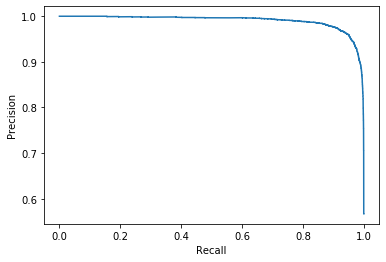

In [46]:
prc.plot()

## precision-recall on Sleep stage W

In [47]:
y_test_0 = np.ones(len(y_test)) - np.array(y_test)

In [48]:
precision, recall, _ = precision_recall_curve(
    y_test_0,
    model.predict_proba(X_test)[:, 0]
)

In [49]:
ind = np.where(recall >= 0.51696047)[0].max()

In [50]:
precision[ind], recall[ind]

(0.999225606608157, 0.5169604700854701)

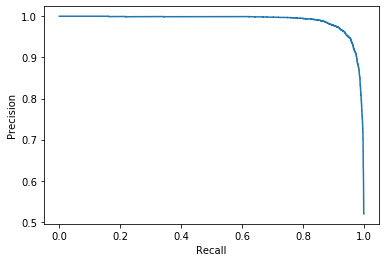

In [51]:
prc = PrecisionRecallDisplay(precision, recall)
prc.plot()